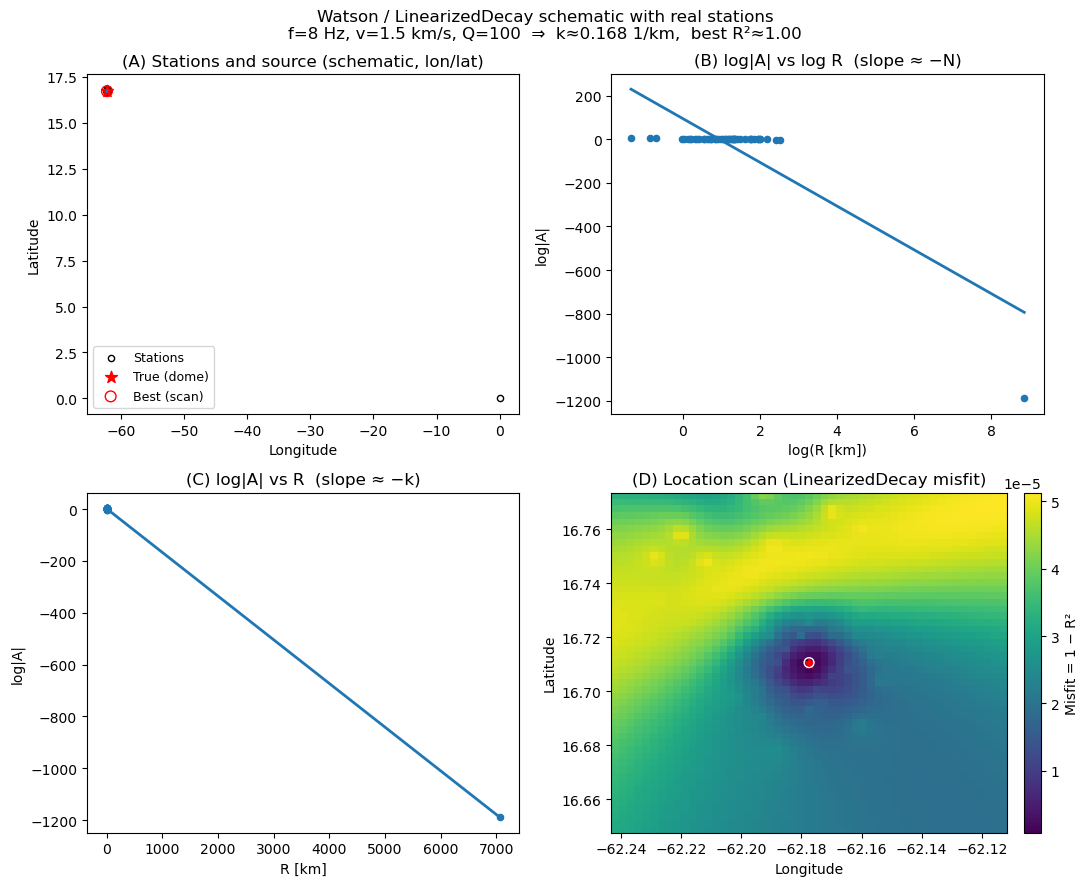

In [1]:
# --- Watson / LinearizedDecay schematic using your real stations ----------------
# Requirements: obspy, numpy, matplotlib
# Assumes INVENTORY_XML is defined (path to your Montserrat XML)
# and flovopy is importable for dome_location.

import numpy as np
import matplotlib.pyplot as plt
from obspy import read_inventory
from obspy.geodetics import gps2dist_azimuth
from flovopy.core.mvo import dome_location

from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read_inventory
from importlib import reload
from flovopy.asl.wrappers import run_single_event, find_event_files, run_all_events
from flovopy.core.mvo import dome_location, REGION_DEFAULT
from flovopy.processing.sam import VSAM, DSAM 
from flovopy.asl.config import ASLConfig, tweak_config
# -------------------------- Config --------------------------
# directories
HOME = Path.home()
PROJECTDIR      = HOME / "Dropbox" / "BRIEFCASE" / "SSADenver"
LOCALPROJECTDIR = HOME / "work" / "PROJECTS" / "SSADenver_local"
METADATA_DIR    = PROJECTDIR / "metadata" 

# master files
INVENTORY_XML   = METADATA_DIR / "MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT     = METADATA_DIR / "MONTSERRAT_DEM_WGS84_MASTER.tif"
GRIDFILE_DEFAULT= METADATA_DIR / "MASTER_GRID_MONTSERRAT.pkl"

# Inventory of Montserrat stations
inv     = read_inventory(INVENTORY_XML)

# ---------------------
# 1) Load station geometry (one lon/lat per station)
# ---------------------


sta_lon, sta_lat, sta_codes = [], [], []
for net in inv:
    for sta in net.stations:
        # Prefer a channel coord if present, else station coord
        lo = None; la = None
        for cha in sta.channels:
            if cha.longitude is not None and cha.latitude is not None:
                lo, la = float(cha.longitude), float(cha.latitude)
                break
        if lo is None or la is None:
            if sta.longitude is not None and sta.latitude is not None:
                lo, la = float(sta.longitude), float(sta.latitude)
        if lo is not None and la is not None:
            sta_lon.append(lo); sta_lat.append(la); sta_codes.append(sta.code)

sta_lon = np.asarray(sta_lon, float)
sta_lat = np.asarray(sta_lat, float)

if sta_lon.size < 3:
    raise RuntimeError("Need ≥3 stations with coordinates in the inventory.")

# ---------------------
# 2) Helper: distances in km from a candidate (lat,lon) to all stations
# ---------------------
def distances_km_to(lat_src, lon_src):
    dkm = np.empty(sta_lon.size, float)
    for i, (la, lo) in enumerate(zip(sta_lat, sta_lon)):
        d_m, _, _ = gps2dist_azimuth(lat_src, lon_src, la, lo)
        dkm[i] = d_m / 1000.0
    return dkm

# ---------------------
# 3) “True” source + synthetic amplitudes from the linearized-decay model
#     log|A_i| ≈ A0_log − N·log(R_i) − k·R_i + ε
#  (Choose k consistent with f, v, Q: k = π f / (Q v) [1/km])
# ---------------------
f_hz = 8.0
v_kms = 1.5
Q     = 100.0
k_true = np.pi * f_hz / (Q * v_kms)       # ≈ 0.167 1/km
N_true = 1.0                               # geometric spreading exponent
A0_log = 3.0                               # arbitrary log amplitude scale
noise_sigma = 0.15                         # log-domain noise

src_lat_true = float(dome_location["lat"])
src_lon_true = float(dome_location["lon"])

R_true = np.clip(distances_km_to(src_lat_true, src_lon_true), 0.01, None)
y_log  = A0_log - N_true * np.log(R_true) - k_true * R_true + np.random.normal(0, noise_sigma, R_true.size)
y_lin  = np.exp(y_log)  # purely for intuition; fitting uses y_log

# ---------------------
# 4) Linearized Watson fit at a candidate point
#     Regress y_log ~ [1, log(R), R]; R² in [0,1]
# ---------------------
def fit_linearized_decay(lat_src, lon_src):
    R = np.clip(distances_km_to(lat_src, lon_src), 0.01, None)
    X = np.column_stack([np.ones_like(R), np.log(R), R])   # [A0_log, −N, −k]
    beta, *_ = np.linalg.lstsq(X, y_log, rcond=None)
    y_hat = X @ beta
    ss_res = np.sum((y_log - y_hat)**2)
    ss_tot = np.sum((y_log - np.mean(y_log))**2)
    r2 = 0.0 if ss_tot <= 0 else 1.0 - ss_res/ss_tot
    return float(r2), beta

r2_true, beta_hat = fit_linearized_decay(src_lat_true, src_lon_true)

# ---------------------
# 5) Scan a ±7 km box around the dome and make a misfit (1−R²) heatmap
# ---------------------
span_km = 7.0
# approximate meters/deg at dome latitude for a small local box
m_per_deg_lat = 111_194.9266
m_per_deg_lon = m_per_deg_lat * np.cos(np.radians(src_lat_true))
dlat_deg = (span_km * 2 * 1000.0) / m_per_deg_lat
dlon_deg = (span_km * 2 * 1000.0) / m_per_deg_lon

n = 51  # 51x51 grid
lat_grid = np.linspace(src_lat_true - dlat_deg/2, src_lat_true + dlat_deg/2, n)
lon_grid = np.linspace(src_lon_true - dlon_deg/2, src_lon_true + dlon_deg/2, n)
R2 = np.empty((n, n), float)

for i, la in enumerate(lat_grid):
    for j, lo in enumerate(lon_grid):
        r2, _ = fit_linearized_decay(la, lo)
        R2[i, j] = r2

misfit = 1.0 - R2
best_idx = np.unravel_index(np.argmin(misfit), misfit.shape)
best_lat, best_lon = lat_grid[best_idx[0]], lon_grid[best_idx[1]]

# ---------------------
# 6) Plots (2×2 schematic)
# ---------------------
fig = plt.figure(figsize=(11, 9))

# (A) Map-like scatter with stations and true source
ax1 = fig.add_subplot(221)
ax1.scatter(sta_lon, sta_lat, s=20, facecolors='white', edgecolors='black', label='Stations')
ax1.scatter([src_lon_true], [src_lat_true], s=80, marker='*', color='red', label='True (dome)')
ax1.scatter([best_lon], [best_lat], s=60, marker='o', facecolors='none', edgecolors='red', label='Best (scan)')
# draw an approximate 7 km circle
theta = np.linspace(0, 2*np.pi, 360)
circle_lon = src_lon_true + (span_km*1000/m_per_deg_lon)*np.cos(theta)
circle_lat = src_lat_true + (span_km*1000/m_per_deg_lat)*np.sin(theta)
ax1.plot(circle_lon, circle_lat, linestyle='--', linewidth=1)
ax1.set_title("(A) Stations and source (schematic, lon/lat)")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.legend(loc='lower left', fontsize=9)

# (B) log|A| vs log(R) (slope ≈ −N)
ax2 = fig.add_subplot(222)
ax2.scatter(np.log(R_true), y_log, s=20)
# regression line at true point
X_log = np.column_stack([np.ones_like(R_true), np.log(R_true)])
b_log, *_ = np.linalg.lstsq(X_log, y_log, rcond=None)
xline = np.linspace(np.log(R_true.min()), np.log(R_true.max()), 100)
ax2.plot(xline, b_log[0] + b_log[1]*xline, linewidth=2)
ax2.set_title("(B) log|A| vs log R  (slope ≈ −N)")
ax2.set_xlabel("log(R [km])")
ax2.set_ylabel("log|A|")

# (C) log|A| vs R (slope ≈ −k)
ax3 = fig.add_subplot(223)
ax3.scatter(R_true, y_log, s=20)
X_R = np.column_stack([np.ones_like(R_true), R_true])
b_R, *_ = np.linalg.lstsq(X_R, y_log, rcond=None)
rline = np.linspace(R_true.min(), R_true.max(), 100)
ax3.plot(rline, b_R[0] + b_R[1]*rline, linewidth=2)
ax3.set_title("(C) log|A| vs R  (slope ≈ −k)")
ax3.set_xlabel("R [km]")
ax3.set_ylabel("log|A|")

# (D) Misfit (1 − R²) over ±7 km around dome (lower is better)
ax4 = fig.add_subplot(224)
im = ax4.imshow(misfit, origin='lower',
                extent=[lon_grid[0], lon_grid[-1], lat_grid[0], lat_grid[-1]],
                aspect='auto')
ax4.scatter([src_lon_true], [src_lat_true], s=60, marker='*', color='red')
ax4.scatter([best_lon], [best_lat], s=50, facecolors='none', edgecolors='white')
cb = plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
cb.set_label("Misfit = 1 − R²")
ax4.set_title("(D) Location scan (LinearizedDecay misfit)")
ax4.set_xlabel("Longitude")
ax4.set_ylabel("Latitude")

fig.suptitle(
    f"Watson / LinearizedDecay schematic with real stations\n"
    f"f={f_hz:g} Hz, v={v_kms:g} km/s, Q={Q:g}  ⇒  k≈{k_true:.3f} 1/km,  best R²≈{(1-misfit.min()):.2f}",
    y=0.98, fontsize=12
)
plt.tight_layout()
plt.show()
